In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as scipy
import statsmodels.stats.multitest as multi
 

%config Completer.use_jedi = False

In [2]:
def dc_assay_data(data_df, grid_df, species):
    new = []
    stand = []
    
    for row in data_df.index:
        for col in data_df.columns:
            info = grid_df.loc[row, col]
            if info[:3] == 'BSA':
                sample_name, sample_conc = info.split("_")
                sample_conc = float(sample_conc)
                meas = float(data_df.loc[row, col])
                stand.append([sample_name, meas, sample_conc])
    
    stand = pd.DataFrame(stand, columns=['sample_name', 'measurement', 'conc'])
    x, y = np.polyfit(stand.measurement.to_numpy(), stand.conc.to_numpy(), 1)

           
    for row in data_df.index:
        for col in data_df.columns:
            info = grid_df.loc[row, col]
            if ((info != 'empty') & (info[:3] != 'BSA')):  
                sample, dil = info.split(';')
                dil = int(dil)
                sample_type, sample_name_info = sample.split("_")
                sample_name = sample_name_info[:-2]
                sample_replicate = sample_name_info[-2:]
                sample_treat = sample_replicate[:1]
                sample_replicate = sample_replicate[-1:]
#                meas = float(data_df.loc[row, col]*dil)
                meas = float(data_df.loc[row, col])
                conc = x*meas+y
                conc = conc*dil
                new.append([sample_name, conc, meas, dil, sample_name_info[-2:], sample_treat, sample_replicate, sample_type])

    new = pd.DataFrame(new, columns=['sample_name', 'conc', 'measurement', 'dilution', 'sample_replicate', 'treatment', 'repliacte', 'sample_type'])
    
    new = new[(new.sample_name == species) & (new.sample_type == 'AF')]
    
    repl = []
    
    for i in np.unique(new.sample_replicate.to_numpy()):
        tech_mean = np.mean(new[new.sample_replicate == i]['conc'].to_numpy())
        
        if i[:1] == 'W':
            treat = 'Mock'
            
        else:
            treat = 'BTH'

        repl.append([species, i, tech_mean, treat])
        
    repl = pd.DataFrame(repl, columns=['sample_name', 'replicate', 'conc', 'treatment'])
    # Make a loop that combines all technical replicates of the Bion-treated samples

        
    print(x, y)
    return(repl, stand, new)

In [3]:
nb_data = pd.read_csv('/home/felix/thesis/chapter3_broader_IS_context/Results/1_AFE/dc/nb/data.csv', sep=',')
nb_grid = pd.read_csv('/home/felix/thesis/chapter3_broader_IS_context/Results/1_AFE/dc/nb/grid.csv', sep=',')

at_data = pd.read_csv('/home/felix/thesis/chapter3_broader_IS_context/Results/1_AFE/dc/at/data.csv', sep=',')
at_grid = pd.read_csv('/home/felix/thesis/chapter3_broader_IS_context/Results/1_AFE/dc/at/grid.csv', sep=',')

gm_data = pd.read_csv('/home/felix/thesis/chapter3_broader_IS_context/Results/1_AFE/dc/gm/data.csv', sep=',')
gm_grid = pd.read_csv('/home/felix/thesis/chapter3_broader_IS_context/Results/1_AFE/dc/gm/grid.csv', sep=',')

In [4]:
nb, nb_bsa, nb_new = dc_assay_data(nb_data, nb_grid, 'Nb')
at, at_bsa, at_new = dc_assay_data(at_data, at_grid, 'At')
gm, gm_bsa, gm_new = dc_assay_data(gm_data, gm_grid, 'Gm')

6.012250185206104 -0.5964751222212971
6.823425750894663 -0.6231511178557313
5.96244947198841 -0.5837840814649772


In [5]:
df = nb.append((at, gm), ignore_index=True)

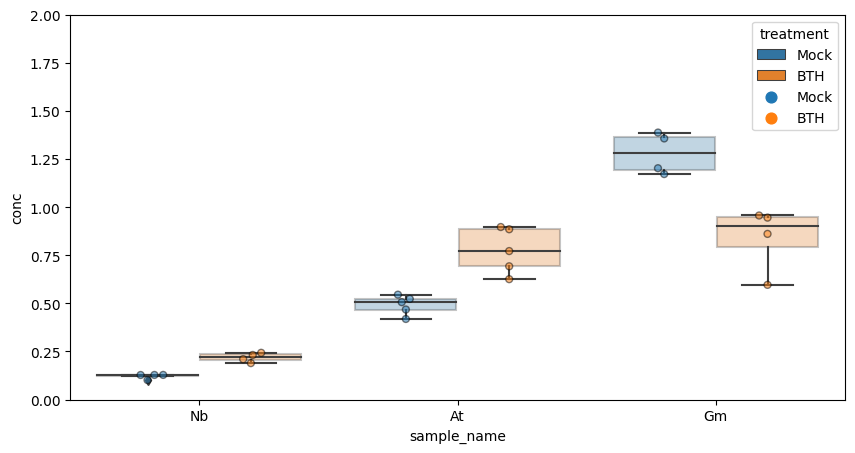

In [6]:
plt.figure(figsize=(10, 5))

sns.boxplot(data=df, x='sample_name', y='conc', hue='treatment', hue_order=['Mock', 'BTH'], boxprops={'alpha':0.3}).set(ylim=(0, 2))
sns.swarmplot(data=df, x='sample_name', y='conc', hue='treatment', hue_order=['Mock', 'BTH'], dodge=True, alpha=0.5, edgecolor='black', linewidth=1)

plt.show()

In [7]:
nb_t, nb_p = scipy.ttest_ind(nb[nb.treatment == 'BTH'].conc.to_numpy(), nb[nb.treatment == 'Mock'].conc.to_numpy())
at_t, at_p = scipy.ttest_ind(at[at.treatment == 'BTH'].conc.to_numpy(), at[at.treatment == 'Mock'].conc.to_numpy())
gm_t, gm_p = scipy.ttest_ind(gm[gm.treatment == 'BTH'].conc.to_numpy(), gm[gm.treatment == 'Mock'].conc.to_numpy())

multi.fdrcorrection([nb_p, at_p, gm_p])

(array([ True,  True,  True]), array([0.00113042, 0.00176422, 0.00455845]))

In [8]:
nb_M = np.mean(nb[nb.treatment == 'Mock'].conc.to_numpy())
nb_B = np.mean(nb[nb.treatment == 'BTH'].conc.to_numpy())

at_M = np.mean(at[at.treatment == 'Mock'].conc.to_numpy())
at_B = np.mean(at[at.treatment == 'BTH'].conc.to_numpy())

gm_M = np.mean(gm[gm.treatment == 'Mock'].conc.to_numpy())
gm_B = np.mean(gm[gm.treatment == 'BTH'].conc.to_numpy())

In [9]:
print(nb_B/nb_M)
print(at_B/at_M)
print(1-(gm_B/gm_M))

1.8020134518166373
1.572816887395453
0.3437685025600381


## MDH activity for each sample

### Average amount of extracted volume in ul per g of fresh leaf

In [10]:
# Establish average volume per g FW extracted from N.benthamiana leaves using data from 06/03/2019

nb_weight = [3.6, 4.3, 3.6, 3.6, 4.1, 5.0, 3.6, 3.6]
nb_volume = [1400, 1750, 1780, 1780, 1950, 2800, 1650, 1600]

new = []

for i in range(len(nb_weight)-1):
    new.append([nb_weight[i], nb_volume[i]])

nb_extracts = pd.DataFrame(new, columns=['weight_g', 'volume_ul'])

nb_extracts['extract_per_FW_ul_per_g'] = nb_extracts['volume_ul']/nb_extracts['weight_g']
print("{} +- {}".format(np.mean(nb_extracts.extract_per_FW_ul_per_g.to_numpy()), np.std(nb_extracts.extract_per_FW_ul_per_g.to_numpy())))

468.38537305638835 +- 53.446015728665174


In [11]:
# Establish average volume per g FW extracted from G,max leaves using data from 11/12/2018

gm_weight = [2.1, 2.7, 2.4, 2.4, 2.0, 2.1, 1.8, 2.2]
gm_volume = [280, 360, 410, 270, 210, 160, 140, 160]

new = []

for i in range(len(gm_weight)-1):
    new.append([gm_weight[i], gm_volume[i]])

gm_extracts = pd.DataFrame(new, columns=['weight_g', 'volume_ul'])

gm_extracts['extract_per_FW_ul_per_g'] = gm_extracts['volume_ul']/gm_extracts['weight_g']
print("{} +- {}".format(np.mean(gm_extracts.extract_per_FW_ul_per_g.to_numpy()), np.std(gm_extracts.extract_per_FW_ul_per_g.to_numpy())))

115.56689342403628 +- 31.13394271240752


In [12]:
# Establish average volume per g FW extracted from A.thaliana leaves using data from 11/12/2018

at_weight = [3.3, 3.5, 2.6, 3.8, 3.2, 2.9]
at_volume = [850, 900, 600, 1050, 750, 600]

new = []

for i in range(len(at_weight)-1):
    new.append([at_weight[i], at_volume[i]])

at_extracts = pd.DataFrame(new, columns=['weight_g', 'volume_ul'])

at_extracts['extract_per_FW_ul_per_g'] = at_extracts['volume_ul']/at_extracts['weight_g']
print("{} +- {}".format(np.mean(at_extracts.extract_per_FW_ul_per_g.to_numpy()), np.std(at_extracts.extract_per_FW_ul_per_g.to_numpy())))

251.23572699230596 +- 16.77653892102132


In [13]:
mdh_at_data = pd.read_csv('/home/felix/thesis/chapter3_broader_IS_context/Results/1_AFE/mdh/at/data.csv')
mdh_at_grid = pd.read_csv('/home/felix/thesis/chapter3_broader_IS_context/Results/1_AFE/mdh/at/grid.csv')
mdh_at_data.drop(columns=['Cycle_nb', 'Temp_C'], inplace=True)
mdh_at_grid.index = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

mdh_nb_data = pd.read_csv('/home/felix/thesis/chapter3_broader_IS_context/Results/1_AFE/mdh/nb/data.csv')
mdh_nb_grid = pd.read_csv('/home/felix/thesis/chapter3_broader_IS_context/Results/1_AFE/mdh/nb/grid.csv')
mdh_nb_data.drop(columns=['Cycle_nb', 'Temp_C'], inplace=True)
mdh_nb_grid.index = ['A', 'B', 'C']


mdh_gm_data = pd.read_csv('/home/felix/thesis/chapter3_broader_IS_context/Results/1_AFE/mdh/gm/data.csv')
mdh_gm_grid = pd.read_csv('/home/felix/thesis/chapter3_broader_IS_context/Results/1_AFE/mdh/gm/grid.csv')
mdh_gm_data.drop(columns=['Cycle_nb', 'Temp_C'], inplace=True)
mdh_gm_grid.index = ['A', 'B', 'C', 'D', 'E', 'F']

In [14]:
volumes = {
    'AF_At':244,
    'TE_AtW1':2469,
    'TE_AtW2':2469,
    'TE_AtB1':1183,
    'TE_AtB2':3175,
    'AF_Nb':465,
    'TE_NbW1':5556,
    'TE_NbB1':4444,
    'AF_Gm':110,
    'TE_GmW1':8197,
    'TE_GmB1':8333
    }


epsilon = 6300
length = 0.51
reaction_volume = 200


# find_nearest from 'https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array'

def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return a.flat[idx]


def mdh_plate_reader(data_df, grid_df, species):
    
    val = []
    neg = []
    
    for row in grid_df.index:
        for col in grid_df.columns:
            info = grid_df.loc[row, col]
            
            if info == 'NoNADH':
                a = 'b'
                
            elif info == 'NoAF':
                a = 'c'
            
            elif info != 'empty':      
                sample, dilution, _ = info.split(';')
                dilution = int(dilution)
                name = sample[3:3+len(species)]
                
                if name == species:
                    comp = sample[:2]
                    sample_name = sample[-2:]
                    trea = sample_name[:1]
                    

                    for counter in data_df.index:
                        if counter == 0:
                            start = float(data_df.loc[counter, '{}{}'.format(row, col)])
                            
                        else:
                            now = float(data_df.loc[counter, '{}{}'.format(row, col)])
                            time = data_df.loc[counter, 'Time_s']
                            val.append([name, sample_name, trea, time, start-now, comp, dilution])
            
    raw_abs = pd.DataFrame(val, columns=['species', 'sample_name', 'treatment', 'time_s', 'absorbance', 'compartment', 'dilution'])
        
    time_point = float(find_nearest(raw_abs.time_s.to_numpy(), 300))
    
    
    # subset to only contain values after measurement closest to after 5 minutes
    
    df_5min = raw_abs[raw_abs.time_s == time_point]
    df_5min.index = range(len(df_5min))
        
    # calculate absorbance per minute, activity U and U per gFW
    
    df_5min['absorbance_per_min'] = df_5min['absorbance']*60/df_5min['time_s']
    df_5min['U'] = df_5min['absorbance_per_min'] * (1/(epsilon*length)) * df_5min['dilution']
    
    for i in df_5min.index:
        comp = df_5min.loc[i, 'compartment']
        spec = df_5min.loc[i, 'species']
        name = df_5min.loc[i, 'sample_name']

        if comp == 'AF':

            sample = "{}_{}".format(comp, spec)
            df_5min.loc[i, 'U_gFW'] = df_5min.loc[i, 'U'] * (volumes.get(sample)/reaction_volume)

        elif comp == 'TE':
            sample = "{}_{}{}".format(comp, spec, name)
            df_5min.loc[i, 'U_gFW'] = df_5min.loc[i, 'U'] * (volumes.get(sample)/reaction_volume)
            
    sample_TE_W = np.mean(df_5min[(df_5min.compartment == 'TE') & (df_5min.treatment == 'W')].U_gFW.to_numpy())
    sample_TE_B = np.mean(df_5min[(df_5min.compartment == 'TE') & (df_5min.treatment == 'B')].U_gFW.to_numpy())
    
        
        
    tmp_W = df_5min[(df_5min.treatment == 'W') & (df_5min.compartment == 'AF')]
    for i in tmp_W.index:
        tmp_W.loc[i, 'U_gFW_per_U_gFWTE'] =  tmp_W.loc[i, 'U_gFW']/sample_TE_W
        
    tmp_B = df_5min[(df_5min.treatment == 'B') & (df_5min.compartment == 'AF')]
    for i in tmp_B.index:
        tmp_B.loc[i, 'U_gFW_per_U_gFWTE'] = tmp_B.loc[i, 'U_gFW']/sample_TE_B
        
    df_5min = tmp_W.append(tmp_B, ignore_index=True)
    df_5min['perc_MDH_cont'] = df_5min['U_gFW_per_U_gFWTE'] * 100
    

    return(raw_abs, df_5min)   

In [15]:
at_abs_tc, at_5min = mdh_plate_reader(mdh_at_data, mdh_at_grid, 'At')
nb_abs_tc, nb_5min = mdh_plate_reader(mdh_nb_data, mdh_nb_grid, 'Nb')
gm_abs_tc, gm_5min = mdh_plate_reader(mdh_gm_data, mdh_gm_grid, 'Gm')

<ipython-input-14-3fc82b02ad89>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_5min['absorbance_per_min'] = df_5min['absorbance']*60/df_5min['time_s']
<ipython-input-14-3fc82b02ad89>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_5min['U'] = df_5min['absorbance_per_min'] * (1/(epsilon*length)) * df_5min['dilution']
/home/felix/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

## Merge technical replicates

In [16]:
def merge_techs(df_data):
    new = []
    for name in np.unique(df_data.sample_name.to_numpy()):
        tmp = df_data[df_data.sample_name == name]
        speci = np.unique(tmp.species.to_numpy())[0]
        treat = np.unique(tmp.treatment.to_numpy())[0]
        times = np.unique(tmp.time_s.to_numpy())[0]
        conta = np.mean(tmp.perc_MDH_cont)
        
        new.append([speci, name, treat, times, conta])
        
    return(pd.DataFrame(new, columns=['species', 'sample_name', 'treatment', 'time_s', 'perc_MDH_cont']))

In [17]:
nb_5min = merge_techs(nb_5min)
gm_5min = merge_techs(gm_5min)

In [18]:
df_mdh = nb_5min.append([at_5min, gm_5min], ignore_index=True)

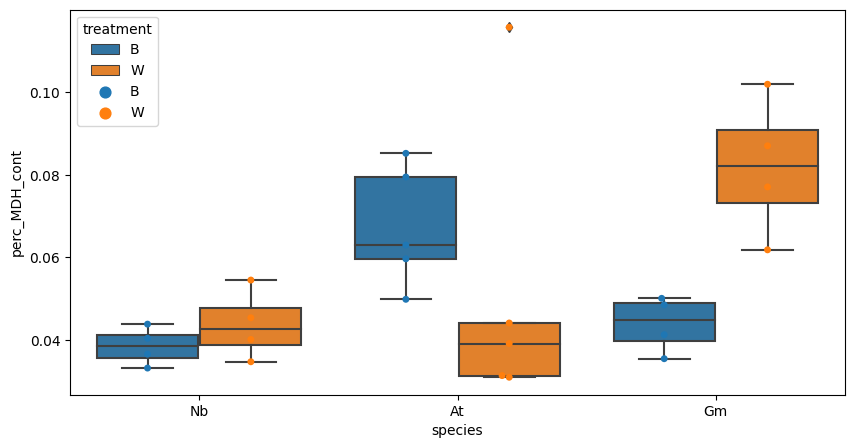

In [19]:
plt.figure(figsize=(10, 5))

sns.boxplot(data=df_mdh, x='species', y='perc_MDH_cont', hue='treatment')
sns.swarmplot(data=df_mdh, x='species', y='perc_MDH_cont', hue='treatment', dodge=True)


plt.show()

In [20]:
nb_M = df_mdh[(df_mdh.species == 'Nb') & (df_mdh.treatment == 'W')].perc_MDH_cont.to_numpy()
nb_B = df_mdh[(df_mdh.species == 'Nb') & (df_mdh.treatment == 'B')].perc_MDH_cont.to_numpy()

at_M = df_mdh[(df_mdh.species == 'At') & (df_mdh.treatment == 'W')].perc_MDH_cont.to_numpy()
at_B = df_mdh[(df_mdh.species == 'At') & (df_mdh.treatment == 'B')].perc_MDH_cont.to_numpy()

at_3M = df_mdh[(df_mdh.species == 'At') & (df_mdh.treatment == 'W') & (df_mdh.sample_name != 'W3')].perc_MDH_cont.to_numpy()

gm_M = df_mdh[(df_mdh.species == 'Gm') & (df_mdh.treatment == 'W')].perc_MDH_cont.to_numpy()
gm_B = df_mdh[(df_mdh.species == 'Gm') & (df_mdh.treatment == 'B')].perc_MDH_cont.to_numpy()

nb_t, nb_p = scipy.ttest_ind(nb_B, nb_M)
at_t, at_p = scipy.ttest_ind(at_B, at_M)
at_3t, at_3p = scipy.ttest_ind(at_B, at_3M)
gm_t, gm_p = scipy.ttest_ind(gm_B, gm_M)

print(nb_p, at_p, at_3p, gm_p)
print(multi.fdrcorrection([nb_p, at_p, at_3p, gm_p]))

print(np.mean(nb_B)/np.mean(nb_M))
print(np.mean(at_B)/np.mean(at_M))
print(np.mean(at_B)/np.mean(at_3M))
print(np.mean(gm_B)/np.mean(gm_M))

0.3219666676363224 0.4071422359881325 0.005701105018673122 0.00570985300226304
(array([False, False,  True,  True]), array([0.40714224, 0.40714224, 0.01141971, 0.01141971]))
0.8815282770287803
1.289749066853381
1.8510420144796265
0.5351273406020741


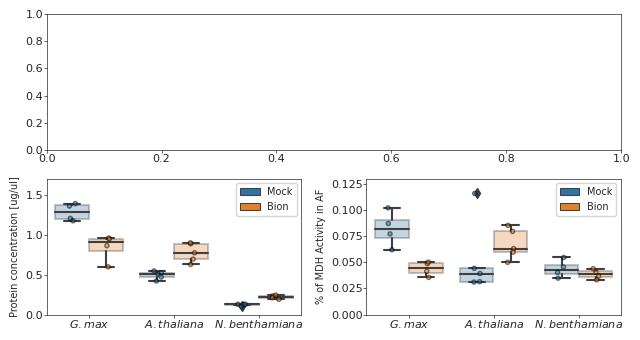

In [34]:
sns.set_style("ticks")

def annotate_axes(axes_list):
    for i, ax in enumerate(axes_list):
        ax.tick_params(axis='both', labelsize=8, pad=0.5)
        # change all spines
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(0.5)
        ax.xaxis.set_tick_params(width=0.5, length=2)
        ax.yaxis.set_tick_params(which='minor', width=0.25, length=2)
        ax.yaxis.set_tick_params(which='major', width=0.5, length=2)


figure = plt.figure(figsize=(6.5, 3.5))

tree = plt.subplot2grid((2, 2), (0, 0), colspan=2)
dc = plt.subplot2grid((2, 2), (1, 0))
mdh = plt.subplot2grid((2, 2), (1, 1))


axes = [tree, dc, mdh]
boxes = [dc, mdh]
annotate_axes(axes)

### Define some arrays ###

species_order = ['Gm', 'At', 'Nb']
species_labels = ['$\itG.max$', '$\itA.thaliana$', '$\itN.benthamiana$']

### Generate individual plots ###

# DC assay

sns.boxplot(data=df, x='sample_name', y='conc', hue='treatment', order=species_order, hue_order=['Mock', 'BTH'], boxprops={'alpha':0.3}, ax=dc)
sns.stripplot(data=df, x='sample_name', y='conc', hue='treatment', order=species_order, hue_order=['Mock', 'BTH'], size=3, dodge=True, alpha=0.5, edgecolor='black', linewidth=1, ax=dc)
dc.set_ylim(0, 1.7)
dc.set_xlabel('')
dc.set_ylabel('Protein concentration [ug/ul]', fontsize=7)
#dc.set_xticklabels(species_labels, rotation=15, ha='right', rotation_mode='anchor', fontsize=6)


#handles, labels = dc.get_legend_handles_labels()
#dc.legend(handles[:2], ['Mock', 'Bion'], ncol=1, loc=1, prop={"size":7}, markerscale=0.5)


# MDH activity

sns.boxplot(data=df_mdh, x='species', y='perc_MDH_cont', hue='treatment', order=species_order, hue_order=['W', 'B'], boxprops={'alpha':0.3}, ax=mdh)
sns.stripplot(data=df_mdh, x='species', y='perc_MDH_cont', hue='treatment', order=species_order, hue_order=['W', 'B'], size=3, dodge=True, alpha=0.5, edgecolor='black', linewidth=1, ax=mdh)
mdh.set_xlabel('')
mdh.set_ylabel('% of MDH Activity in AF', fontsize=7)
mdh.set_ylim(0, 0.13)
#mdh.set_xticklabels(species_labels, rotation=15, ha='right', rotation_mode='anchor', fontsize=6)

for box in boxes:
    handles, labels = box.get_legend_handles_labels()
    box.legend(handles[:2], ['Mock', 'Bion'], ncol=1, loc=1, prop={'size':7}, markerscale=0.5)
    box.set_xticklabels(species_labels, fontsize=8)


plt.tight_layout()
#plt.tight_layout(pad=0.75, h_pad=0.001)
plt.savefig('/home/felix/thesis/chapter3_broader_IS_context/Results/1_AFE/Figure1_jupyter.svg', transparent=True)
plt.show()